# SNSプラットフォーム アーキテクチャ設計
作成日: 2024年11月
作成者: 辛島 実

## システム概要
- テキストや写真・動画によりユーザの非同期コミュニケーションを実現するSNS
- コンテンツ投稿（動画・写真・音声等）、リアルタイムチャット、高度な検索機能、プッシュ通知、通話、ライブストリーミングなどの主要なSNS機能を備える

## AWS構成図
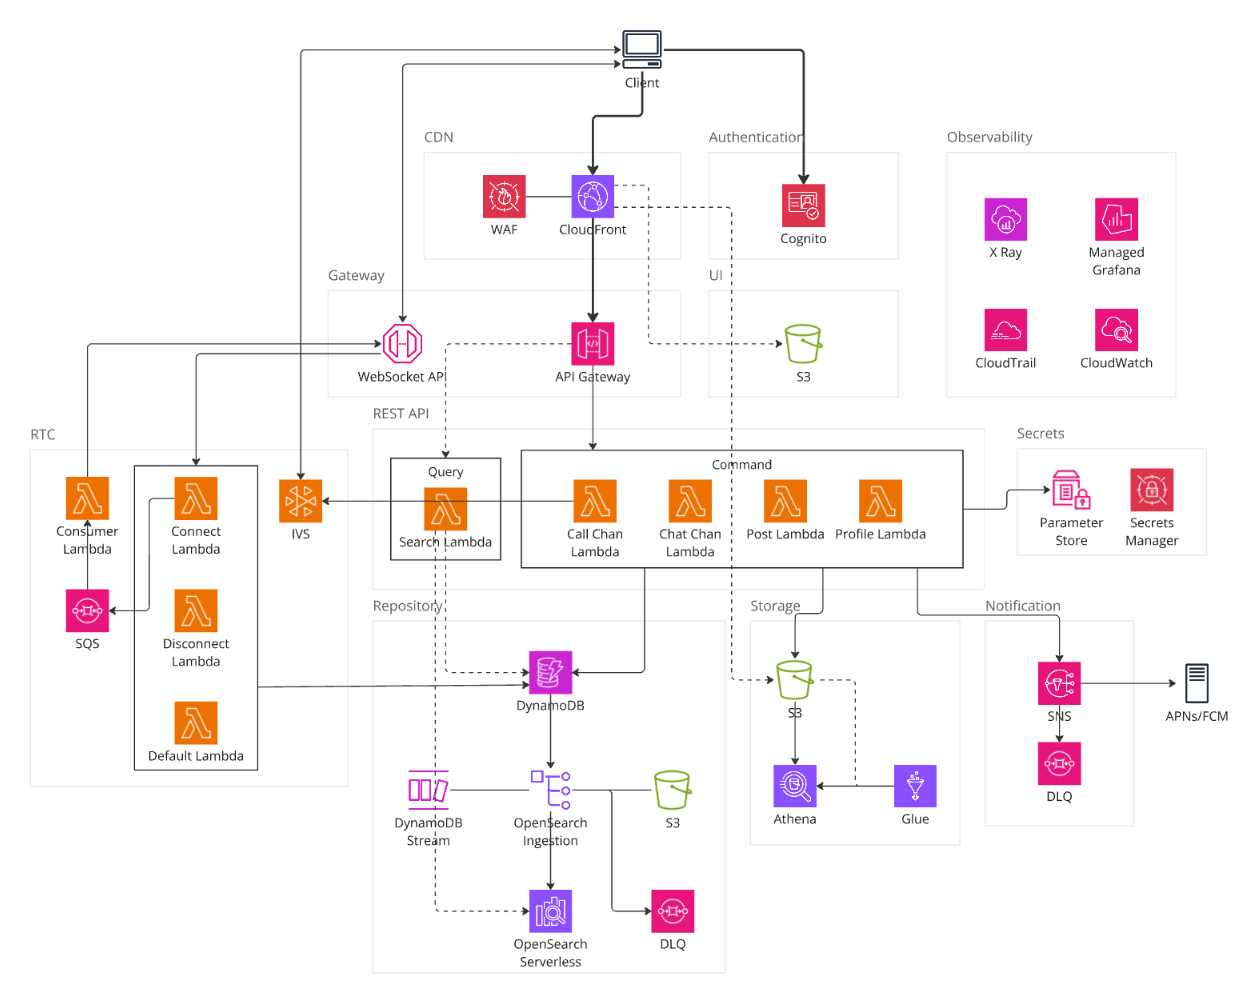

## 機能の説明

| 機能 | 役割 | 実装 |
|------|------|------|
| CDN | コンテンツの効率的な配信とアクセス制御 | CloudFrontとWAF、SSL証明書の一元管理、[Origin Access Control](https://aws.amazon.com/jp/blogs/news/amazon-cloudfront-introduces-origin-access-control-oac/)ポリシーによるs3アクセス制御 |
| Gateway | APIリクエストの統合的な制御と管理 | API GatewayでJWTの一元的な検証、Lambda呼び出し、APIバージョン切り替え、負荷対策 |
| UI | フロントエンド配信 | svelteで書いてS3でホスト |
| Authentication | ユーザー認証とリソースアクセスに関する各種機能の提供 | CognitoのUser Pools とIdentity Poolsを使用した認証基盤。User Poolsではユーザー登録・サインインの標準的なフローを提供しJWTトークンを発行。Identity Poolを通じて認証済みユーザーに対する一時的なAWSクレデンシャルを発行。これにより、特定のAWSリソースへのアクセスを安全に制御。OIDCプロバイダーとの統合により、外部IDプロバイダー経由のサインインもサポート |
| API | システムの中核となるドメインロジック | Lambdaで実装、 [Provisioned Concurrency](https://aws.amazon.com/blogs/aws/new-provisioned-concurrency-for-lambda-functions/#:~:text=Today%20we%20are%20launching%20Provisioned%20Concurrency%2C%20a%20feature,and%20mobile%20backends%2C%20latency-sensitive%20microservices%2C%20or%20synchronous%20APIs.)を用いてコールドスタート対策 |
| Repository | テキスト情報の永続化 | DynamoDB, OpenSearch, DynamoDB Stream, S3, DLQで[Zero ETL統合](https://docs.aws.amazon.com/ja_jp/amazondynamodb/latest/developerguide/bp-integration-opensearch.html)、必要に応じて[DAX](https://docs.aws.amazon.com/amazondynamodb/latest/developerguide/DAX.html)による高速化 |
| Storage | ファイルの永続化 | ユーザーが投稿したメディアファイルなどをS3に保存、[Athena/Glueで分析](https://aws.amazon.com/blogs/big-data/visualize-amazon-s3-data-using-amazon-athena-and-amazon-managed-grafana) |
| RTC | リアルタイムコミュニケーション | WebSocket API、Amazon IVSで[リアルタイムチャット](https://github.com/aws-samples/websocket-chat-application)と[通話機能やライブストリーミング](https://aws.amazon.com/blogs/media/add-multiple-hosts-to-live-streams-with-amazon-ivs/)の提供 |
| Notification | プッシュ通知の配信 | Amazon SNS, DLQ |
| Observability | システム全体の監視と分析 | CloudWatchでシステム性能メトリクス収集・監視, X-Rayで分散トレーシング, CloudTrailで操作履歴の記録・監査, Managed Grafanaで[S3](https://aws.amazon.com/blogs/big-data/visualize-amazon-s3-data-using-amazon-athena-and-amazon-managed-grafana/)や[DynamoDB](https://grafana.com/grafana/plugins/grafana-dynamodb-datasource/)や[OpenSearch](https://grafana.com/grafana/plugins/grafana-opensearch-datasource/)を可視化とダッシュボード作成 |
| SecretsManager | APIキーや秘密鍵の一元管理 | SecretsManager |

## 考慮事項

| 分類 | 対策 | 実装 |
|------|------|----------|
| 可用性 | インフラの信頼性確保、コンテンツ配信の安定化、メッセージング処理の信頼性、データの永続性と復旧性確保 | AWSマネージドサービスによる99.999%可用性、マルチAZ構成によるインフラ冗長化、ユーザーデータの自動バックアップと復旧、CloudFrontによるグローバルCDN活用とレイテンシ低減、キャッシュ戦略の最適化によるオリジン負荷軽減、SQS/DLQによる非同期処理と失敗メッセージの捕捉/再処理、SNSによる信頼性の高いプッシュ通知配信、DynamoDB PITRによる任意時点へのリカバリ機能、OpenSearch Ingestionと連携したバックアップ戦略 |
| スケーラビリティ | システム拡張性の確保、パフォーマンスの最適化、開発効率の向上、アーキテクチャの柔軟性 | マネージドサービスによる自動スケーリング、トラフィックに応じた適切なリソース割り当て、コスト最適化を考慮したスケーリング設定、Lambdaのコールドスタート対策（Provisioned Concurrency）、DAXクラスターによるDynamoDB読み取り性能向上、CDNによるコンテンツ配信最適化、AWS CDK/GitによるIaC/CI/CD、クリーンアーキテクチャによる疎結合設計、Lambda Powertoolsの活用 |
| セキュリティ | 認証/認可、攻撃対策、監視と異常検知、通信セキュリティ、構成情報の保護 | CognitoによるOAuth2/OIDC認証、WAFによるハッキング対策、各種監視サービスによる異常検知、CDN/GatewayによるDDoS対策、HTTPS/WSSによる暗号化通信、Parameter Storeによるconfig暗号化、Secrets Managerによるapiキー暗号化 |
